#  Прогнозирование заказов такси

Компания «Очень аккуратное такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Требуется построить модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

План:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.

Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import os
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics import tsaplots
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from catboost import CatBoostRegressor, Pool
import lightgbm as lgb

plt.rcParams['figure.figsize'] = (10,6)

FILE_NAME = 'taxi.csv'
RANDOM_STATE = 12345

In [2]:
path1 = '../data/' + FILE_NAME
path2 = 'https://code.s3.yandex.net/datasets/' + FILE_NAME

if os.path.exists(path1):
    path = path1 
else:
    path = path2

data = pd.read_csv(path, index_col=[0], parse_dates=[0])
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


Временной интервал у записей — 10 минут.

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [4]:
data.describe()

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


## Анализ

Проверим что значения индекса идут по порядку.

In [5]:
data.index.is_monotonic_increasing

True

In [6]:
print('Минимум :', data.index.min())
print('Максимум:', data.index.max())

Минимум : 2018-03-01 00:00:00
Максимум: 2018-08-31 23:50:00


Проведем ресемплирование записей, поменяв интервал на 1 час, сохранив оригинальные данные в переменной *data_orig*.

In [7]:
data_orig = data.copy()
data = data.resample('1H').sum()
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


In [8]:
data.describe()

,num_orders
count,4416.000000
mean,84.422781
std,45.023853
min,0.000000
25%,54.000000
50%,78.000000
75%,107.000000
max,462.000000


In [9]:
data[data['num_orders'] == 0].count()

num_orders    1
dtype: int64

In [10]:
data[data['num_orders'] == 0]

,num_orders
datetime,
2018-04-06 06:00:00,0


Некритично, всего одно нулевое значение. Возможно, 6-го апреля в 6 утра действительно не было заказов.

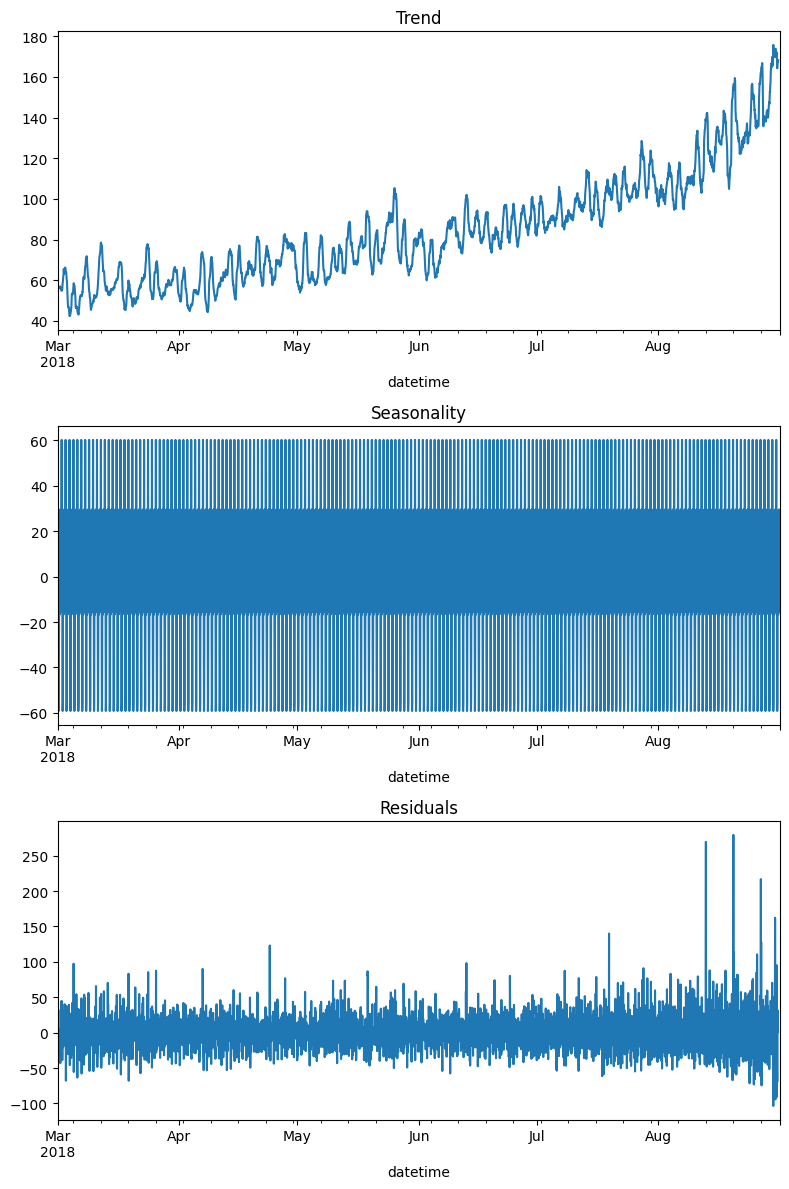

In [11]:
decomposed = seasonal_decompose(data)

plt.figure(figsize=(8, 12))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout();

С марта по август, несмотря на летний сезон, тренд восходящий — количество заказов уверенно растет. На протяжении почти всего датасета тренд линейный, а в августе заметно ускорение (переход к квадратичному тренду).

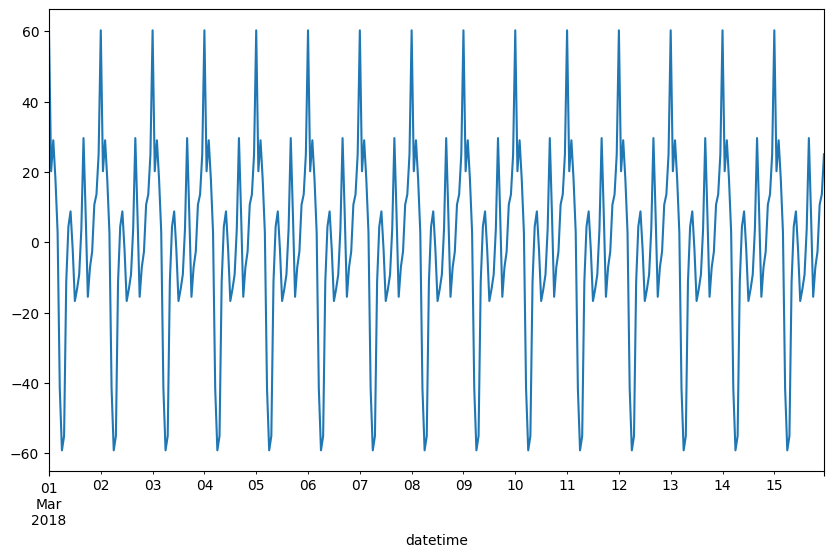

In [12]:
decomposed.seasonal['2018-03-01':'2018-03-15'].plot();

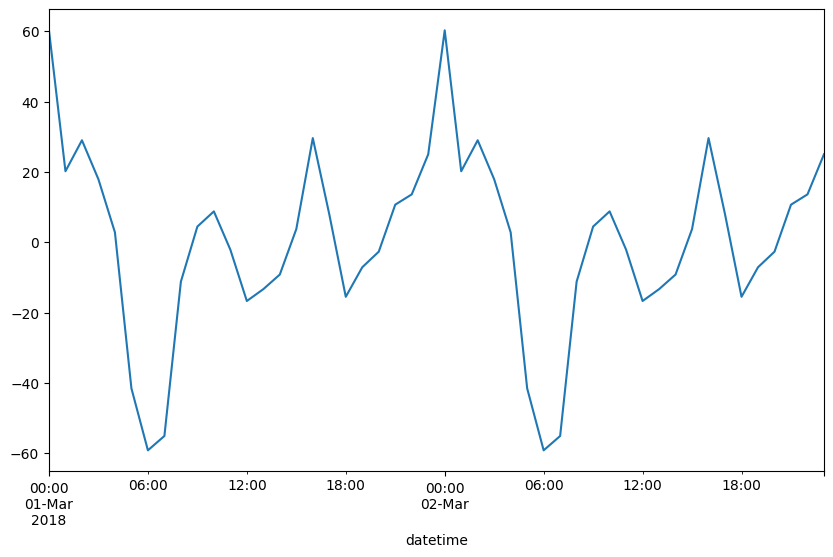

In [13]:
decomposed.seasonal['2018-03-01':'2018-03-02'].plot();

"Сезонность" носит суточный характер с минимумом в 6 утра и с максимумом в 0 часов.

Теперь проверим данные на недельную сезонность. Для этого проведем ресемплирование оригинальных данных с интервалом в 1 день.

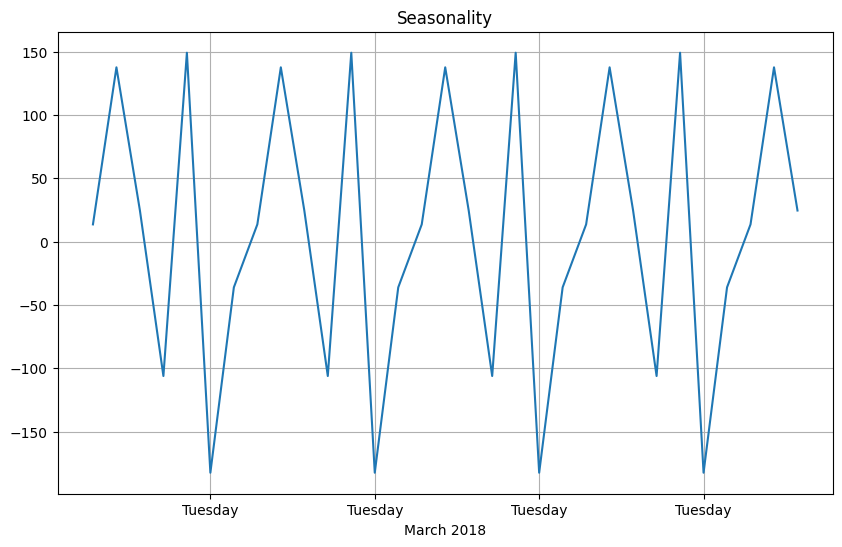

In [14]:
data_1d = data_orig.resample('1D').sum()
decomposed_1d = seasonal_decompose(data_1d)

fig, ax = plt.subplots()
ax.plot(decomposed_1d.seasonal['2018-03-01':'2018-03-31'])
# ax.set_title('Seasonality')
ax.grid('both')
ax.set(title='Seasonality', xlabel='March 2018')
ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%A'))

**Вывод**: в данных очень четко видны два типа сезонности — суточная и недельная.

### Создание признаков

Создадим дополнительные признаки, которые подчеркнут характер наших данных:
* Календарные признаки *hour*, *day*, *dayofweek* (данные только за один 2018 год);
* Отстающие признаки за 24 часа и дополнительно с лагом в 168 часов (1 неделя);
* Скользящее среднее со значением окна в 2 значения.

In [15]:
ROLLING_MEAN_SIZE = 2

def make_features(data, max_lag, rolling_mean_size):
    new_data = data.copy()
    new_data['hour'] = new_data.index.hour
    new_data['day'] = new_data.index.day
    new_data['dayofweek'] = new_data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        new_data['lag_{}'.format(lag)] = new_data['num_orders'].shift(lag)
    # one week shift - обязательный признак
    new_data['lag_168'] = new_data['num_orders'].shift(168)
    new_data['rolling_mean'] = new_data['num_orders'].shift().rolling(rolling_mean_size).mean()

    return new_data

In [16]:
data_upd = make_features(data, 24, ROLLING_MEAN_SIZE)
train, test = train_test_split(data_upd, shuffle=False, test_size=0.1)
print(f'train: {train.shape}')
print(f'test: {test.shape}')

train: (3974, 30)
test: (442, 30)


In [17]:
train = train.dropna()

features_train = train.drop(['num_orders'], axis=1)
features_test  = test.drop(['num_orders'], axis=1)
target_train   = train.num_orders
target_test    = test.num_orders

print(f'features_train: {features_train.shape}')
print(f'features_test: {features_test.shape}')

features_train: (3806, 29)
features_test: (442, 29)


## Обучение

In [18]:
models = {
    'LinearRegression': LinearRegression(),
    'CatBoostRegressor': CatBoostRegressor(
        random_state=RANDOM_STATE,
        verbose=0
    ),
    'LGBMRegressor': lgb.LGBMRegressor(
        force_col_wise=True,
        verbosity=-1,
        random_state=RANDOM_STATE
    )
}

grid_params = {
    'LinearRegression': {},
    'CatBoostRegressor': {
        'learning_rate': [0.01, 0.02, 0.03],
        'depth': [4, 5],
    },
    'LGBMRegressor': {
        'learning_rate': [0.06, 0.08, 0.1],
        'max_depth': [4, 5],        
    }
}

In [19]:
tscv = TimeSeriesSplit(n_splits=5)

best_estimators = {}

for name, model in models.items():
    gsearch = GridSearchCV(
        estimator=model, cv=tscv, refit=True,
        param_grid=grid_params[name], scoring='neg_root_mean_squared_error'
    )
    gsearch.fit(features_train, target_train)
    print(f'{name}. Лучшее значение RMSE: {-gsearch.best_score_}. Лучшие параметры: {gsearch.best_params_}')
    best_estimators[name] = gsearch.best_estimator_
    

LinearRegression. Лучшее значение RMSE: 22.948747447559946. Лучшие параметры: {}
CatBoostRegressor. Лучшее значение RMSE: 22.362419177803226. Лучшие параметры: {'depth': 4, 'learning_rate': 0.03}
LGBMRegressor. Лучшее значение RMSE: 22.68623076555382. Лучшие параметры: {'learning_rate': 0.08, 'max_depth': 4}


На обучающей выборке с использованием кросс-валидации и с подбором гиперпараметров у моделей *CatBoostRegressor* и *LGBMRegressor* (с помощью GridSearchCV) получили следующие значения RMSE:
* CatBoostRegressor. Лучшее значение RMSE: 22.39. Лучшие параметры: {'depth': 4, 'learning_rate': 0.02}
* LGBMRegressor. Лучшее значение RMSE: 22.69. Лучшие параметры: {'learning_rate': 0.08, 'max_depth': 4}
* LinearRegression. Лучшее значение RMSE: 22.95.

## Тестирование

Проведем тестирование лучших моделей, обучившихся на кросс-валидации.

In [20]:
for name, model in models.items():
    estimator = best_estimators[name]
    target_test_pred = estimator.predict(features_test)
    print(f'{name}. RMSE тестовой выборки:', mean_squared_error(target_test, target_test_pred, squared=False))

LinearRegression. RMSE тестовой выборки: 35.01191576943891
CatBoostRegressor. RMSE тестовой выборки: 39.72174148745758
LGBMRegressor. RMSE тестовой выборки: 38.34781695904137


На тестовой выборке ситуация противоположная. Бустинги переобучились и запомнили данные, тогда как линейная модель неплохо обобщила выборку и запомнила закономерности. По значениям RMSE места между моделями распределились так:
1. *LinearRegression* — 35.01;
2. *LGBMRegressor* — 38.35;
3. *CatBoostRegressor* — 39.43.


### Важность признаков

#### CatBoostRegressor

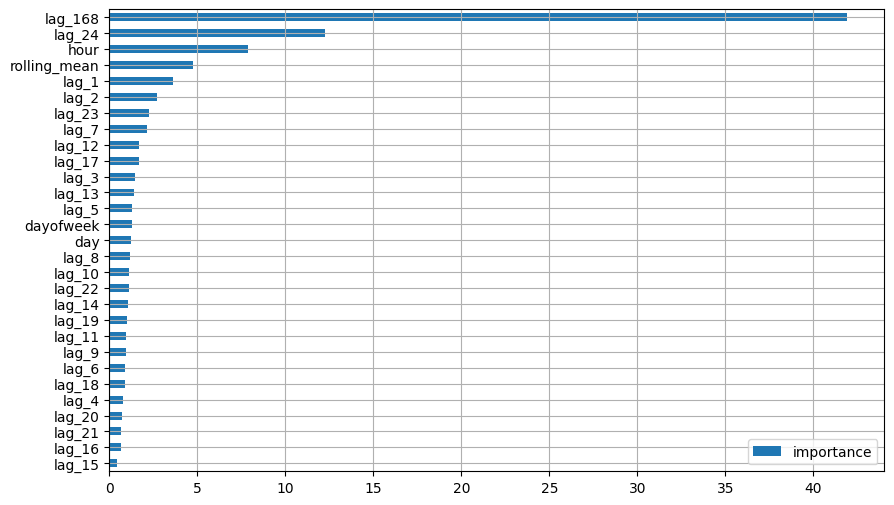

In [21]:
cb_feature_importances = best_estimators['CatBoostRegressor'].get_feature_importance()
cb_feature_importances_df = pd.DataFrame(index=features_test.columns, data=cb_feature_importances, columns=['importance'])
fig, ax = plt.subplots()
cb_feature_importances_df.sort_values(by='importance').plot.barh(ax=plt.gca());
ax.grid(True)

Ниже построим функцию автокорреляции, где будет также видна важность отстающих значений.

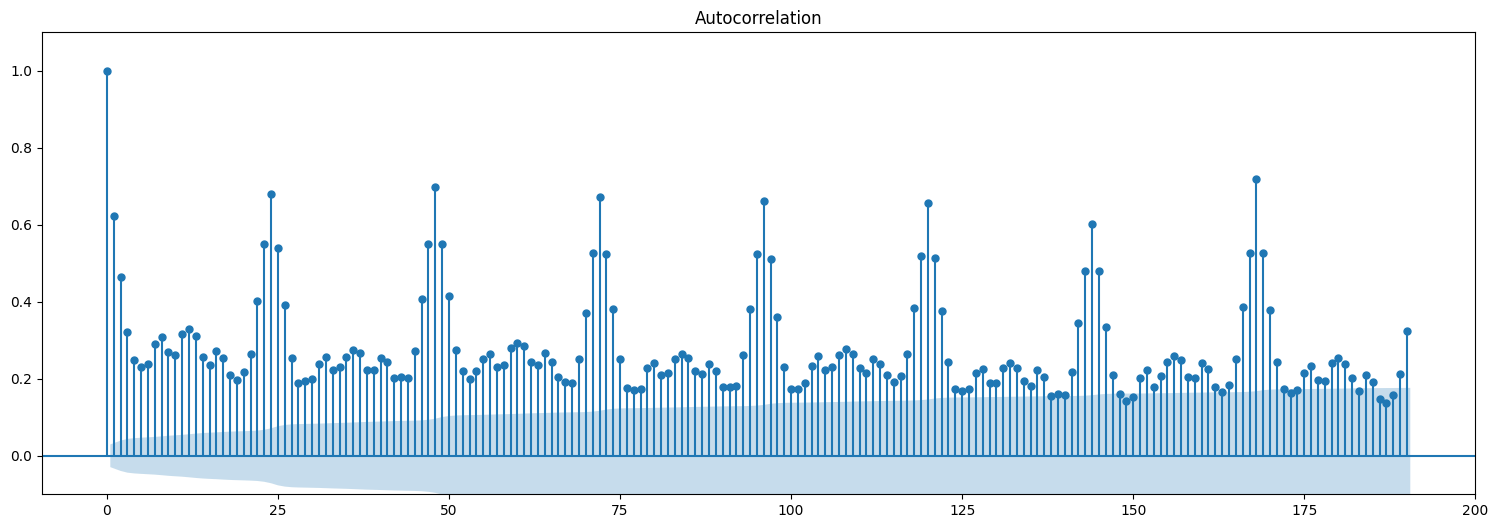

In [22]:
taxi = pd.read_csv(path, index_col=[0], parse_dates=[0]).resample('1H').sum()
ts = taxi['num_orders']

fig = tsaplots.plot_acf(ts,lags= 190)
fig.set_size_inches(18.5, 6)
plt.ylim(-.1, 1.1)
plt.show() 



#### LGBMRegressor

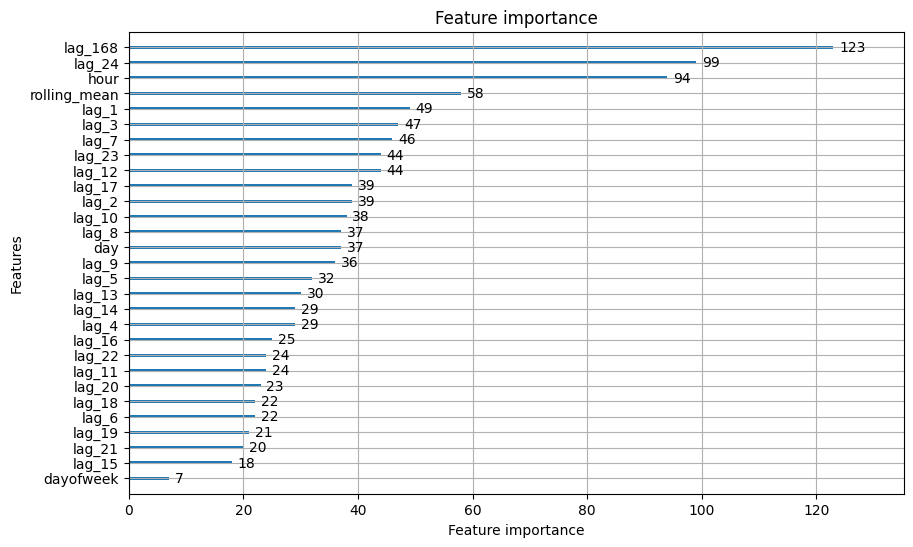

In [23]:
lgb.plot_importance(best_estimators['LGBMRegressor']);

Видно, что у обоих моделей наиболее значимые признаки *lag_168* и *lag_24*, что отражает недельную и суточную "сезонность".

### Проверка моделей на адекватность

Прогноз с использованием предыдущего значения временного ряда.

In [24]:
pred_previous = target_test.shift()
pred_previous.iloc[0] = target_train.iloc[-1]
print('DummyModel. RMSE тестовой выборки:', mean_squared_error(target_test, pred_previous, squared=False))

DummyModel. RMSE тестовой выборки: 58.856486242815066


## Результаты исследования

Предоставленные данные по заказу такси с 1-го марта по 31-е августа 2018 года имеют восходящий тренд (количество заказов уверенно растет), а также хорошо выраженную недельную и суточную сезонность.

Для обучения моделей сгенерировали дополнительные признаки, которые подчеркивают характер наших данных:
* Календарные признаки *hour*, *day*, *dayofweek* (данные только за один 2018 год);
* Отстающие признаки за 24 часа и дополнительно с лагом в 168 часов (1 неделя);
* Скользящее среднее со значением окна в 2 значения.

Наибольший вклад в точность предсказания внесли два *lag features* — с недельным и суточным отставанием.

В нашем случае скользящее среднее со значением окна равное 2 является оптимальным для моделей с бустингом. При его увеличении точность прогноза моделей с бустингом незначительно снижается, зато у модели линейной регрессии также незначительно увеличивается.

На обучающей выборке с использованием кросс-валидации и с подбором гиперпараметров у моделей *CatBoostRegressor* и *LGBMRegressor* (с помощью GridSearchCV) получили следующие значения RMSE:
* CatBoostRegressor. Лучшее значение RMSE: 22.39. Лучшие параметры: {'depth': 4, 'learning_rate': 0.02}
* LGBMRegressor. Лучшее значение RMSE: 22.69. Лучшие параметры: {'learning_rate': 0.08, 'max_depth': 4}
* LinearRegression. Лучшее значение RMSE: 22.95.

На тестовой выборке ситуация противоположная. По значениям RMSE места между моделями распределились так:
1. *LinearRegression* — 35.01;
2. *LGBMRegressor* — 38.35;
3. *CatBoostRegressor* — 39.43.


Подбор гиперпараметров в нашем случае не играет такой важной роли, как выбор и создание правильных признаков.

Все модели прошли проверку на адекватность — при прогнозе с исопльзованием предыдущего значения временного ряда, RMSE = 58.86. 